# Load Data


In [ ]:
!rm -rf *data*
!mkdir -p ./data/sets/nuimages  # Make the directory to store the nuImages dataset in.

!pip install nuscenes-devkit &> /dev/null  # Install nuImages.

# !wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

# !tar -xf nuimages-v1.0-mini.tgz -C ./data/sets/nuimages  # Uncompress the nuImages mini split.

## Load Samples


In [3]:
!wget https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-samples.tgz

!tar -xf nuimages-v1.0-all-samples.tgz -C ./data/sets/nuimages  # Uncompress the entire nuImages samples.

--2025-04-05 19:25:49--  https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-samples.tgz
Resolving d36yt3mvayqw5m.cloudfront.net (d36yt3mvayqw5m.cloudfront.net)... 108.156.78.205, 108.156.78.61, 108.156.78.96, ...
Connecting to d36yt3mvayqw5m.cloudfront.net (d36yt3mvayqw5m.cloudfront.net)|108.156.78.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16381401772 (15G) [application/x-tar]
Saving to: ‘nuimages-v1.0-all-samples.tgz’

nuimages-v1.0-all-s 100%[===================>]  15.26G  10.9MB/s    in 18m 30s 

2025-04-05 19:44:20 (14.1 MB/s) - ‘nuimages-v1.0-all-samples.tgz’ saved [16381401772/16381401772]



## Load Metadata


In [2]:
!wget https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-metadata.tgz

!tar -xf nuimages-v1.0-all-metadata.tgz -C ./data/sets/nuimages  # Uncompress the entire nuImages metadata.

--2025-04-05 19:24:32--  https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-metadata.tgz
Resolving d36yt3mvayqw5m.cloudfront.net (d36yt3mvayqw5m.cloudfront.net)... 108.156.78.205, 108.156.78.78, 108.156.78.61, ...
Connecting to d36yt3mvayqw5m.cloudfront.net (d36yt3mvayqw5m.cloudfront.net)|108.156.78.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 639386088 (610M) [application/x-tar]
Saving to: ‘nuimages-v1.0-all-metadata.tgz’

nuimages-v1.0-all-m 100%[===================>] 609.77M  17.0MB/s    in 54s     

2025-04-05 19:25:26 (11.4 MB/s) - ‘nuimages-v1.0-all-metadata.tgz’ saved [639386088/639386088]



In [6]:
# List how many files/samples each split has
!grep -o '"token":' ./data/sets/nuimages/v1.0-mini/sample.json | wc -l
!grep -o '"token":' ./data/sets/nuimages/v1.0-train/sample.json | wc -l
!grep -o '"token":' ./data/sets/nuimages/v1.0-test/sample.json | wc -l
!grep -o '"token":' ./data/sets/nuimages/v1.0-val/sample.json | wc -l

50
67279
9752
16445


In [24]:
# Remove the unnecessary data (test & mini set)
!rm -rf ./data/sets/nuimages/v1.0-mini/
!rm -rf ./data/sets/nuimages/v1.0-test/

In [4]:
import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

PyTorch version: 2.6.0+cu124
Using device: cpu


In [7]:
# Pfad zum NuImages-Datensatz (lokal)
DATA_SET_PATH = "data/sets/nuimages"

# Ausgabepfad für die YOLO-Trainingsdaten
output_path = "data/nuimages_yolo"
os.makedirs(output_path, exist_ok=True)

vehicle_mapping = {
    "human.pedestrian.adult": "person",
    "vehicle.car": "vehicle.car",
    "vehicle.motorcycle": "vehicle.motorcycle",
    "vehicle.bus.rigid": "vehicle.bus",
    "vehicle.bus.bendy": "vehicle.bus",
    "vehicle.truck": "vehicle.truck",
    "vehicle.trailer": "vehicle.truck",
    "movable_object.trafficcone": "trafficcone",
}


# Get class index for YOLO format
vehicle_class_names = list(dict.fromkeys(vehicle_mapping.values()))

In [41]:
from nuimages import NuImages
from tqdm import tqdm
import os

nuimTrain = NuImages(dataroot=DATA_SET_PATH, version="v1.0-train", verbose=True, lazy=True)
nuimVal = NuImages(dataroot=DATA_SET_PATH, version="v1.0-val", verbose=True, lazy=True)
SAMPLES = nuimTrain.sample
#SAMPLES = SAMPLES[:2000]
selected_sample = SAMPLES[0]

token = selected_sample["token"]
key_camera_token = selected_sample["key_camera_token"]

print("Selected Sample: ", selected_sample)

Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).
Loading nuImages tables for version v1.0-val...
Done loading in 0.000 seconds (lazy=True).
Loaded 67279 sample(s) in 0.103s,
Selected Sample:  {'token': '0000ad4e5f8440649a605e59b140bbe6', 'timestamp': 1514952516307486, 'log_token': 'ddefc6e23b5147a4bb04f51ebcb8ddb1', 'key_camera_token': 'd7419240c6aa4cc9ae257b18e9b6087f'}


In [26]:
selected_sample_data = nuimTrain.get("sample_data", key_camera_token)
print(selected_sample_data)

Loaded 872181 sample_data(s) in 5.754s,
{'token': 'd7419240c6aa4cc9ae257b18e9b6087f', 'sample_token': '0000ad4e5f8440649a605e59b140bbe6', 'ego_pose_token': '1a142f7ef2254f319f317aed28ebbe8f', 'calibrated_sensor_token': '1a775865ec6a57e1acbb48ff1ba48b6d', 'filename': 'samples/CAM_BACK_RIGHT/n003-2018-01-03-12-03-23+0800__CAM_BACK_RIGHT__1514952516307486.jpg', 'fileformat': 'jpg', 'width': 1600, 'height': 900, 'timestamp': 1514952516307486, 'is_key_frame': True, 'prev': '60bb92030e4d442d9b7e363bffffdbc7', 'next': 'e73871a17d1342a3ae763cf40b55e9f3'}


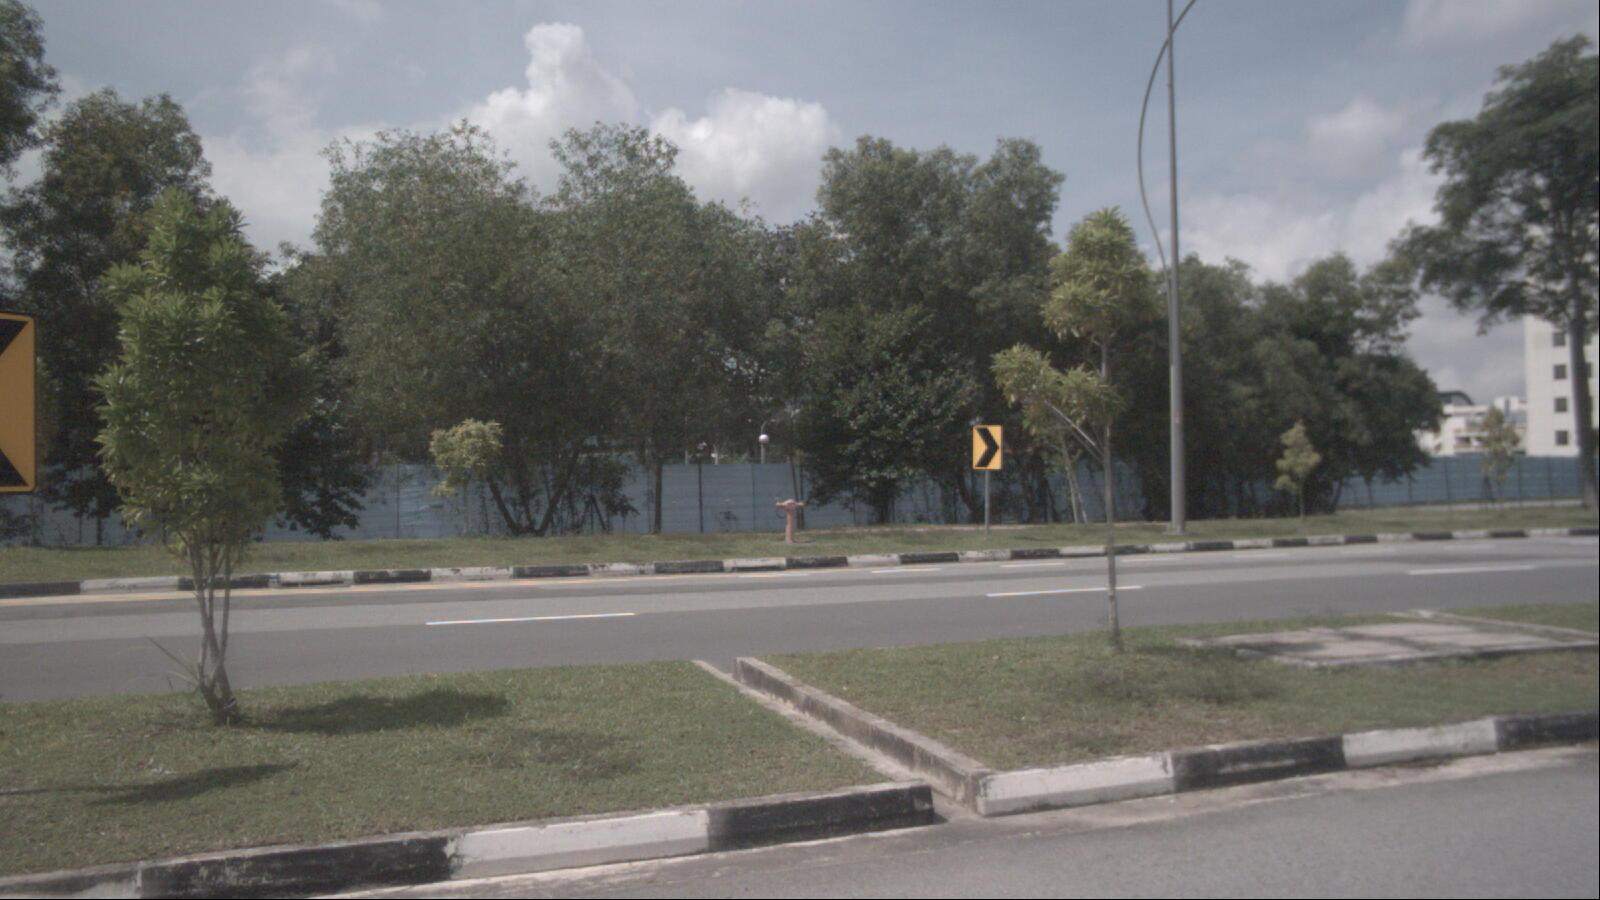

In [27]:
filename = DATA_SET_PATH + "/" + selected_sample_data["filename"]

from IPython.display import Image

Image(filename)

In [28]:
object_tokens, _ = nuimTrain.list_anns(token, verbose=False)
if len(object_tokens) > 0:
  print(object_tokens[0])
  object_info = nuimTrain.get("object_ann", object_tokens[0])
  print(object_info)
  annotation_category = nuimTrain.get("category", object_info["category_token"])
  print(annotation_category)

Loaded 557715 object_ann(s) in 11.013s,
Loaded 73755 surface_ann(s) in 2.360s,
Loaded 25 category(s) in 0.001s,


## Filter for vehicle classes


/usr/local/lib/python3.11/dist-packages/nuimages/utils/utils.py:71: UserWarning: No suitable fonts were found in your system. A default font will be used instead (the font size will not be adjustable).
  warnings.warn('No suitable fonts were found in your system. '


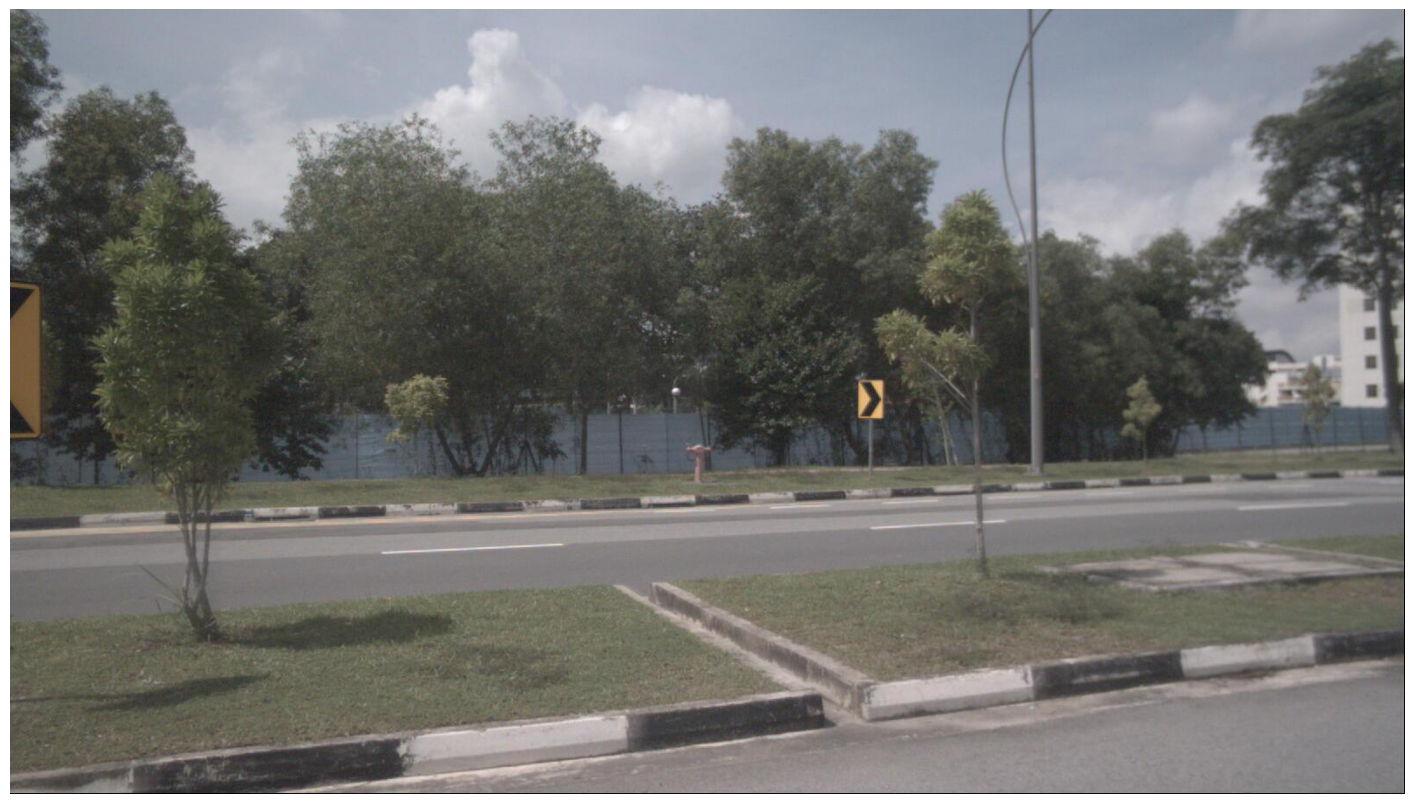

In [29]:
filtered_tokens = []
for token in object_tokens:
    object_info = nuimTrain.get("object_ann", token)
    annotation_category = nuimTrain.get("category", object_info["category_token"])
    print(annotation_category["name"], object_info)
    if annotation_category["name"] in vehicle_mapping.keys():
        filtered_tokens.append(token)

nuimTrain.render_image(
    key_camera_token,
    with_category=True,
    object_tokens=filtered_tokens,
    surface_tokens=[],
    font_size=24,
    render_scale=2,
    box_line_width=4
)

# Process Data


## Filter Front Camera(s) Images


In [42]:
# Front-Kamera-Bilder identifizieren (für Fahrzeuge, die sich wegbewegen)
def filter_straight_camera_images(nuim_loader):
    """Filtert Bilder aus der Frontkamera."""
    all_samples = nuim_loader.sample
    front_camera_samples = []

    for sample in all_samples:
        key_camera_token = sample["key_camera_token"]
        sample_data = nuim_loader.get("sample_data", key_camera_token)
        filename = sample_data["filename"]
        is_key_frame = sample_data["is_key_frame"]
        if is_key_frame and ("__CAM_FRONT__" in filename or "__CAM_BACK__" in filename):
            front_camera_samples.append(sample)

    print(f"Gefiltert: {len(front_camera_samples)} Bilder")
    print(f"Von: {len(all_samples)} Bildern ({(len(front_camera_samples)/len(all_samples))*100}%)")
    return front_camera_samples


filtered_samples_train = filter_straight_camera_images(nuimTrain)
filtered_samples_val = filter_straight_camera_images(nuimVal)

Loaded 872181 sample_data(s) in 5.514s,
Gefiltert: 25441 Bilder
Von: 67279 Bildern (37.81417678621858%)
Loaded 16445 sample(s) in 0.025s,
Loaded 213185 sample_data(s) in 1.057s,
Gefiltert: 6258 Bilder
Von: 16445 Bildern (38.05411979325023%)


## Get Image Annotations


In [43]:
# NuImages-Kategorien laden und filtern
categories = nuimTrain.category
categories_val = nuimVal.category
object_categories = {}

assert len(categories) == len(categories_val)
assert categories == categories_val

for category in categories:
    # Wenn die Kategorie in unserem Mapping ist, speichern wir ihre Token-ID
    lower_name = category["name"].lower()
    if lower_name in vehicle_mapping.keys():
        object_categories[category["token"]] = {
            "name": lower_name,
            "yolo_name": vehicle_mapping[lower_name],
        }

print(f"Extrahierte Fahrzeugkategorien: {len(object_categories)}")
for token, info in object_categories.items():
    print(f"{token}  - {info['name']}: (New YOLO-Name: {info['yolo_name']})")


Loaded 25 category(s) in 0.001s,
Loaded 25 category(s) in 0.000s,
Extrahierte Fahrzeugkategorien: 8
1fa93b757fc74fb197cdd60001ad8abf  - human.pedestrian.adult: (New YOLO-Name: person)
85abebdccd4d46c7be428af5a6173947  - movable_object.trafficcone: (New YOLO-Name: trafficcone)
003edbfb9ca849ee8a7496e9af3025d4  - vehicle.bus.bendy: (New YOLO-Name: vehicle.bus)
fedb11688db84088883945752e480c2c  - vehicle.bus.rigid: (New YOLO-Name: vehicle.bus)
fd69059b62a3469fbaef25340c0eab7f  - vehicle.car: (New YOLO-Name: vehicle.car)
dfd26f200ade4d24b540184e16050022  - vehicle.motorcycle: (New YOLO-Name: vehicle.motorcycle)
90d0f6f8e7c749149b1b6c3a029841a8  - vehicle.trailer: (New YOLO-Name: vehicle.truck)
6021b5187b924d64be64a702e5570edf  - vehicle.truck: (New YOLO-Name: vehicle.truck)


In [47]:
def annotations_by_sample(nuim_loader, filtered_samples):
  annotations_by_sample = {}

  for sample in tqdm(filtered_samples, desc="Extrahiere Annotationen"):
      sample_token = sample["token"]
      annotations_by_sample[sample_token] = []

      # Alle Objekt-Annotationen für dieses Sample abrufen
      annotations, _ = nuim_loader.list_anns(sample_token, verbose=False)

      for annotation_id in annotations:
          ann = nuim_loader.get("object_ann", annotation_id)
          category_token = ann["category_token"]

          # Prüfen, ob es eine Fahrzeugkategorie ist, die wir behalten wollen
          if category_token in object_categories:
              # Bounding Box im Format [x1, y1, x2, y2] extrahieren
              bbox = ann["bbox"]

              # Kategorie-Information hinzufügen
              annotations_by_sample[sample_token].append(
                  {
                      "category_token": category_token,
                      "yolo_name": object_categories[category_token]["yolo_name"],
                      "bbox": bbox,
                  }
              )
  return annotations_by_sample

# annotations_by_sample_train = annotations_by_sample(nuimTrain, filtered_samples_train)
annotations_by_sample_val = annotations_by_sample(nuimVal, filtered_samples_val)

Extrahiere Annotationen: 100%|██████████| 6258/6258 [02:03<00:00, 50.66it/s]


## YOLO Dataset Prepare


In [57]:
import os
from pathlib import Path

# 1. Erstelle die notwendigen Verzeichnisse für YOLO-Training
train_path = Path(output_path) / "train"
val_path = Path(output_path) / "val"
train_images_path = train_path / "images"
train_labels_path = train_path / "labels"
val_images_path = val_path / "images"
val_labels_path = val_path / "labels"


def recreate_dirs():
    # Clear train and val directories if they exist
    if train_path.exists():
        shutil.rmtree(train_path)
    if val_path.exists():
        shutil.rmtree(val_path)

    # Verzeichnisse erstellen
    for dir_path in [
        train_images_path,
        train_labels_path,
        val_images_path,
        val_labels_path,
    ]:
        dir_path.mkdir(parents=True, exist_ok=True)


recreate_dirs()

In [53]:
import random

# 2. Die Samples zwischen Training und Validierung aufteilen (80% / 20%)
#random.seed(42)  # Für Reproduzierbarkeit
#val_split = 0.15

#random.shuffle(filtered_samples)
#split_idx = int(len(filtered_samples) * (1 - val_split))
#train_samples = filtered_samples[:split_idx]
#val_samples = filtered_samples[split_idx:]

train_samples = filtered_samples_train
val_samples = filtered_samples_val

print(
    f"Training: {len(train_samples)} Samples, Validierung: {len(val_samples)} Samples"
)

Training: 25441 Samples, Validierung: 6258 Samples


In [58]:
# 3. Bilder kopieren und Annotations-Dateien erstellen
import cv2
IMG_RESIZE_FACTOR = 0.8
processed_samples = {"train": 0, "val": 0}
processed_annotations = {"train": 0, "val": 0}


# YOLO-Format-Funktion: Konvertiert BBox [xmin, ymin, xmax, ymax] zu [class_id, x_center, y_center, width, height]
def convert_to_yolo_format(bbox, img_width, img_height, class_id):
    """
    Konvertiert Bounding Box von [xmin, ymin, xmax, ymax] zu YOLO-Format [x_center, y_center, width, height]
    Alle Werte werden auf Bildgröße normalisiert (0-1)
    """
    xmin, ymin, xmax, ymax = bbox

    # Normalisierte Breite und Höhe
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    width_percent = width * 100
    height_percent = height * 100
    min_area_to_cover_percent = 2 # 2% der Bildfläche
    if width_percent * height_percent < min_area_to_cover_percent**2:
      return None

    # Normalisierte Zentrumskoordinaten
    x_center = (xmin + (xmax - xmin) / 2) / img_width
    y_center = (ymin + (ymax - ymin) / 2) / img_height

    return [class_id, x_center, y_center, width, height]


for dataset_type, samples in [("train", train_samples), ("val", val_samples)]:
    output_img_dir = train_images_path if dataset_type == "train" else val_images_path
    output_label_dir = train_labels_path if dataset_type == "train" else val_labels_path
    annotations_map = annotations_by_sample_train if dataset_type == "train" else annotations_by_sample_val
    nuim_loader = nuimTrain if dataset_type == "train" else nuimVal

    for sample in tqdm(samples, desc=f"Erstelle {dataset_type.capitalize()}-Dataset"):
        sample_token = sample["token"]
        key_camera_token = sample["key_camera_token"]

        # Bildpfad ermitteln
        sample_data = nuim_loader.get("sample_data", key_camera_token)
        img_path = Path(DATA_SET_PATH) / sample_data["filename"]

        if not img_path.exists():
            print(f"Warnung: Bild {img_path} nicht gefunden, überspringe...")
            continue

        img_height, img_width = sample_data["height"], sample_data["width"]

        # Zielbildpfad
        dest_img_name = f"{sample_token}.jpg"
        dest_img_path = output_img_dir / dest_img_name
        #dest_img_size = (int(1600 * IMG_RESIZE_FACTOR), int(900 * IMG_RESIZE_FACTOR))

        #img_data = cv2.imread(str(img_path))
        #if img_data is None:
        #    print(f"Warnung: Bild {img_path} konnte nicht geladen werden, überspringe...")
        #    continue

        #resized_img_data = cv2.resize(img_data, dest_img_size, interpolation=cv2.INTER_LINEAR)
        #cv2.imwrite(str(dest_img_path), resized_img_data)
        # Bild kopieren
        shutil.copy(img_path, dest_img_path)

        # Symbolischen Link erstellen anstatt das Bild zu kopieren
        # Absolute Pfade für Quell- und Zieldateien verwenden
        # source_absolute = os.path.abspath(img_path)

        # if os.path.lexists(dest_img_path):
        #     os.remove(dest_img_path)  # Entferne existierenden Symlink falls vorhanden

        # os.symlink(source_absolute, dest_img_path)
        processed_samples[dataset_type] += 1

        # Annotationen im YOLO-Format erstellen
        annotations = annotations_map.get(sample_token, [])
        if not annotations:
            # Leere Annotationsdatei erstellen, wenn keine Fahrzeuge vorhanden sind
            with open(output_label_dir / f"{sample_token}.txt", "w") as f:
                pass
            continue

        with open(output_label_dir / f"{sample_token}.txt", "w") as f:
            for ann in annotations:
                bbox = ann["bbox"]
                yolo_class_name = ann["yolo_name"]

                class_id = vehicle_class_names.index(yolo_class_name)
                # Zu YOLO-Format konvertieren
                yolo_bbox = convert_to_yolo_format(
                    bbox, img_width, img_height, class_id
                )
                # Wenn die Bounding Box zu klein ist, überspringen
                # (z.B. weniger als 2% der Bildfläche)
                if yolo_bbox is None:
                    continue

                # In Datei schreiben: class_id x_center y_center width height
                f.write(
                    f"{yolo_bbox[0]} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f} {yolo_bbox[4]:.6f}\n"
                )
                processed_annotations[dataset_type] += 1


Erstelle Val-Dataset: 100%|██████████| 6258/6258 [02:08<00:00, 48.52it/s]


In [55]:
import yaml
# 4. YAML-Konfigurationsdatei für YOLO erstellen
yaml_content = {
    "path": os.path.abspath(output_path),
    "train": "train/images",
    "val": "val/images",
    "nc": len(vehicle_class_names),
    "names": vehicle_class_names,
}

with open(Path(output_path) / "dataset.yaml", "w") as f:
    yaml.dump(yaml_content, f, sort_keys=False)

shutil.copy(Path(DATA_SET_PATH) / "LICENSE", Path(output_path))

print(f"\nDataset vorbereitet:")
print(
    f"- {processed_samples['train']} Trainingsbilder mit {processed_annotations['train']} Annotationen"
)
print(
    f"- {processed_samples['val']} Validierungsbilder mit {processed_annotations['val']} Annotationen"
)
print(f"- Konfiguration gespeichert in {Path(output_path) / 'dataset.yaml'}")


Dataset vorbereitet:
- 25441 Trainingsbilder mit 185608 Annotationen
- 6258 Validierungsbilder mit 44131 Annotationen
- Konfiguration gespeichert in data/nuimages_yolo/dataset.yaml


In [59]:
# Zip the filtered dataset
# !rm -rf ./data/sets
!zip -r nuimages_yolo_filtered.zip data/nuimages_yolo

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: data/nuimages_yolo/train/labels/eec150ecd0bc42b2b2f799aad1f9624a.txt (deflated 13%)
  adding: data/nuimages_yolo/train/labels/02bf263df6b249ff8fefc463960c6d64.txt (deflated 44%)
  adding: data/nuimages_yolo/train/labels/04907d1e87ec4f858747a77275194393.txt (deflated 42%)
  adding: data/nuimages_yolo/train/labels/5c9e67ca7aec4d3a988c474deaaf4569.txt (deflated 55%)
  adding: data/nuimages_yolo/train/labels/a7a707068682451eb9f69859af9bf0a9.txt (deflated 42%)
  adding: data/nuimages_yolo/train/labels/6c455ff39f814bfd85f8e5e4dd270f04.txt (deflated 43%)
  adding: data/nuimages_yolo/train/labels/ba9040b093474153861ab5d12e110579.txt (deflated 40%)
  adding: data/nuimages_yolo/train/labels/8ad3e9d311d9425ab8cfa742e8891fc6.txt (stored 0%)
  adding: data/nuimages_yolo/train/labels/efac7460c06a419099ea5999c4d2d7c3.txt (stored 0%)
  adding: data/nuimages_yolo/train/labels/dfd32da7f81348d9956a71b9bf540d5f.txt (deflated 62%)